# Chapter 5. RNN 구현하기
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Deep_Learning/

/content/gdrive/MyDrive/Deep_Learning


모델 형상

![](./image/image_62.jpg)

## 0. 라이브러리 호출
---

In [3]:
import torch
import torch.nn as nn
import torch.autograd 
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time

from dataset import ptb

## 1. device 설정
---

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #  torch.cuda.is_available() GPU를 사용가능하면 True, 아니라면 False를 리턴

print("지금 사용하는 device :",device)

지금 사용하는 device : cuda:0


## 2. 데이터셋 준비
---

In [5]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
print(corpus.shape)

(929589,)


In [6]:
corpus_size = 1000
corpus = corpus[:corpus_size]
print(corpus.shape)

(1000,)


In [7]:
vocab_size = int(max(corpus) + 1)

In [8]:
xs = corpus[:-1] # 입력
ys = corpus[1:] # 출력
data_size = len(xs)

## 3. 신경망 생성
---

In [9]:
class TimeEmbedding(nn.Module):
    def __init__(self, vocab_size, wordvec_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, wordvec_size) # (단어 크기, 입력 벡터 차원 수)
        self.V = vocab_size
        self.D = wordvec_size

    def forward(self, xs):
        N, T = xs.shape # N: 미니배치 크기, T: 시계열 데이터

        out = torch.zeros(N,T,self.D)
        out = out.to(device)

        for t in range(T):
            out[:,t,:] = self.embedding(xs[:,t])

        return out

In [10]:
class TimeAffine(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()
        self.H = hidden_size
        self.V = vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        N, T, D = x.shape

        out = x.reshape(N*T, -1) # 3차원 행렬을 곱할 수단은 없으니 2차원 행렬로 변환 (N*T, H)로 변환
        out = self.linear(out)
        out = out.reshape(N,T,-1) # 다시 (N, T, V로 변환)

        return out



In [11]:
class TimeSoftmaxWithLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.loss_layer = nn.CrossEntropyLoss()

    def forward(self, xs, ts):
        N, T, V = xs.shape

        xs = xs.reshape(N*T, V)
        ts = ts.reshape(N*T)

        ys = self.softmax(xs)
        loss = self.loss_layer(ys, ts)

        return loss

### simple RNNLM(RNN Language Model)의 완성

In [12]:
class SimpleRnnlm(nn.Module):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        super().__init__()
        V, D, H = vocab_size, wordvec_size, hidden_size

        self.TimeEmbedding = TimeEmbedding(V,D)
        self.TimeRNN = nn.RNN(D,H, batch_first = True)
        self.TimeAffine = TimeAffine(H,V)
        self.loss_layer = TimeSoftmaxWithLoss()

    def forward(self, xs, ts):
        out = self.TimeEmbedding(xs)
        out, _ = self.TimeRNN(out, None)
        out = self.TimeAffine(out)
        loss = self.loss_layer(out, ts)
        return loss

## 4. 모델 설정 완료
---

In [13]:
# 하이퍼 파라미터 설정
batch_size = 10
wordvec_size = 100 # 입력 벡터 차원 수 (시계열 데이터 수)
hidden_size = 100 # 은닉 상태 벡터 수
time_size = 5 # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기 
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력
data_size = len(xs) # 길이는 999
print('data_size : ',data_size)
print('말뭉치 크기 : %d, 어휘 수 %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)


data_size :  999
말뭉치 크기 : 1000, 어휘 수 418


## 5. 모델 학습
---


In [14]:
# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size # -1을 한 이유는 0부터 시작하기 때문, jump = 시계열 데이터의 총 수 / 미니배치, 이 경우 99가 jump임

offsets = [i * jump for i in range(batch_size)] # 오프셋 각 미니배치의 시작 원소를 담고 있다. [0, 99, 99x2, 99x3, ...]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = torch.empty((batch_size, time_size), dtype=torch.long) # (10,5)
        batch_t = torch.empty((batch_size, time_size), dtype=torch.long) # (10,5)

        for t in range(time_size): # 처리할 수 있는 시간 크기
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)
        model.to(device)

        # 기울기를 구하여 매개변수 갱신
        loss = model(batch_x, batch_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = torch.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| 에폭 1 | 퍼플렉서티 417.97
| 에폭 2 | 퍼플렉서티 417.97
| 에폭 3 | 퍼플렉서티 417.98
| 에폭 4 | 퍼플렉서티 417.97
| 에폭 5 | 퍼플렉서티 417.98
| 에폭 6 | 퍼플렉서티 417.97
| 에폭 7 | 퍼플렉서티 417.97
| 에폭 8 | 퍼플렉서티 417.98
| 에폭 9 | 퍼플렉서티 417.97
| 에폭 10 | 퍼플렉서티 417.97
| 에폭 11 | 퍼플렉서티 417.97
| 에폭 12 | 퍼플렉서티 417.97
| 에폭 13 | 퍼플렉서티 417.97
| 에폭 14 | 퍼플렉서티 417.97
| 에폭 15 | 퍼플렉서티 417.97
| 에폭 16 | 퍼플렉서티 417.97
| 에폭 17 | 퍼플렉서티 417.96
| 에폭 18 | 퍼플렉서티 417.96
| 에폭 19 | 퍼플렉서티 417.97
| 에폭 20 | 퍼플렉서티 417.97
| 에폭 21 | 퍼플렉서티 417.96
| 에폭 22 | 퍼플렉서티 417.96
| 에폭 23 | 퍼플렉서티 417.97
| 에폭 24 | 퍼플렉서티 417.97
| 에폭 25 | 퍼플렉서티 417.96
| 에폭 26 | 퍼플렉서티 417.96
| 에폭 27 | 퍼플렉서티 417.96
| 에폭 28 | 퍼플렉서티 417.96
| 에폭 29 | 퍼플렉서티 417.96
| 에폭 30 | 퍼플렉서티 417.96
| 에폭 31 | 퍼플렉서티 417.96
| 에폭 32 | 퍼플렉서티 417.95
| 에폭 33 | 퍼플렉서티 417.96
| 에폭 34 | 퍼플렉서티 417.95
| 에폭 35 | 퍼플렉서티 417.96
| 에폭 36 | 퍼플렉서티 417.96
| 에폭 37 | 퍼플렉서티 417.95
| 에폭 38 | 퍼플렉서티 417.96
| 에폭 39 | 퍼플렉서티 417.95
| 에폭 40 | 퍼플렉서티 417.95
| 에폭 41 | 퍼플렉서티 417.96
| 에폭 42 | 퍼플렉서티 417.95
| 에폭 43 | 퍼플렉서티 417.96
| 에폭 44 | 퍼플렉서티 417.

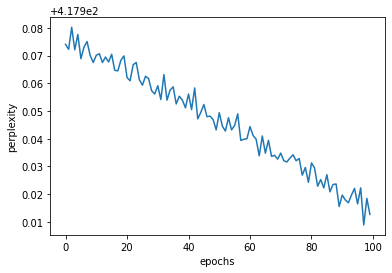

In [15]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
